[PyNN](https://github.com/NeuralEnsemble/PyNN) is a neural simulation language which works well with the [NEST](https://github.com/nest/nest-simulator) simulator. Here I show my progress in using both with python 3 and how to show results in a notebook.

<!-- TEASER_END -->


First, let's install NEST. Note that the compiler switches to ``cmake`` are only necessary on OSX; under Linux, things should work without them.

    git clone https://github.com/nest/nest-simulator.git
    cd nest-simulator
    cmake -DCMAKE_C_COMPILER=gcc-6 -DCMAKE_CXX_COMPILER=g++-6  -DCMAKE_INSTALL_PREFIX:PATH=/usr/local/nest -DPYTHON_EXECUTABLE=/usr/local/bin/python3 -DPYTHON_INCLUDE_DIR=/usr/local/Frameworks/Python.framework/Versions/3.5/include/python3.5m/ -DPYTHON_LIBRARY=/usr/local/Frameworks/Python.framework/Versions/3.5/lib/libpython3.5.dylib  .    make
    make install

Then, you have to update your shell using:

    # NEST
    export PATH=/usr/local/nest/bin:$PATH
    export PYTHONPATH=/usr/local/nest/lib/python1.4/site-packages


and now pyNN:

    git clone https://github.com/NeuralEnsemble/PyNN
    cd pyNN
    pip3 install -e .
    examples/tools
    ipython3 run_all_examples.py NEST


I (still) used this patch:

    diff --git a/pyNN/nest/simulator.py b/pyNN/nest/simulator.py
    index 625c121..335f925 100644
    --- a/pyNN/nest/simulator.py
    +++ b/pyNN/nest/simulator.py
    @@ -78,7 +78,7 @@ class _State(common.control.BaseState):
         def min_delay(self):
             # this rather complex implementation is needed to handle min_delay='auto'
             kernel_delay = nest.GetKernelStatus('min_delay')
    -        syn_delay = nest.GetDefaults('static_synapse')['min_delay']
    +        syn_delay = nest.GetDefaults('static_synapse')['delay']
             if syn_delay == numpy.inf or syn_delay > 1e300:
                 return kernel_delay
             else:


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH
Mean firing rate:  18.9 Hz


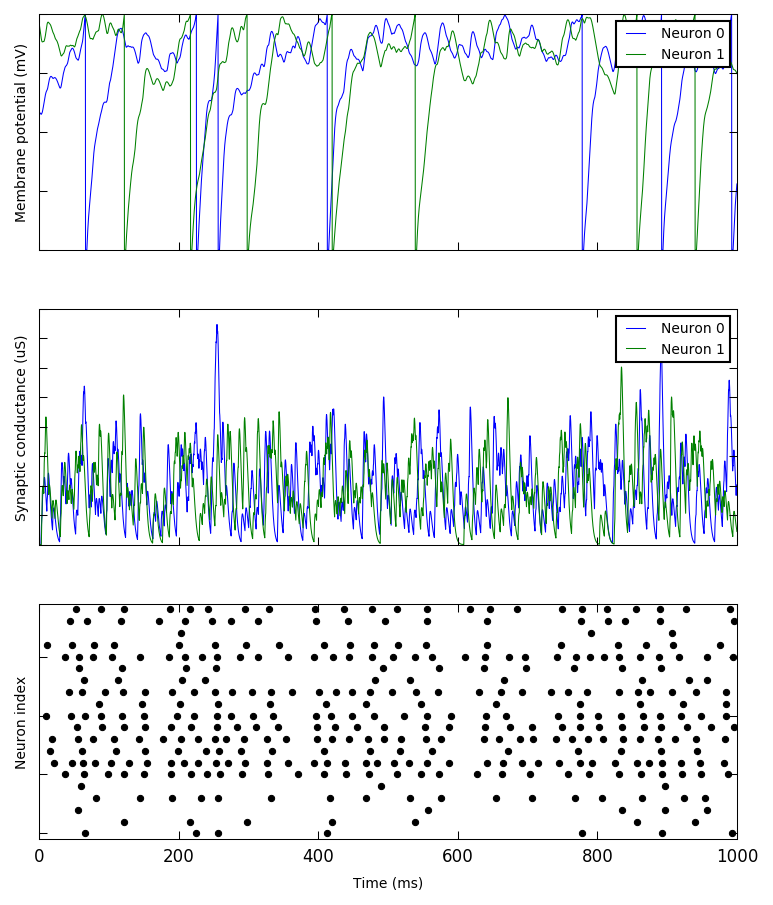

In [1]:
%matplotlib inline

import pyNN.nest as sim

import numpy
from pyNN.utility import get_simulator, init_logging, normalized_filename
from pyNN.parameters import Sequence
from pyNN.random import RandomDistribution as rnd


# === Define parameters ========================================================

n = 20      # Number of cells
w = 0.002  # synaptic weight (µS)
cell_params = {
    'tau_m'      : 20.0,   # (ms)
    'tau_syn_E'  : 2.0,    # (ms)
    'tau_syn_I'  : 4.0,    # (ms)
    'e_rev_E'    : 0.0,    # (mV)
    'e_rev_I'    : -70.0,  # (mV)
    'tau_refrac' : 2.0,    # (ms)
    'v_rest'     : -60.0,  # (mV)
    'v_reset'    : -70.0,  # (mV)
    'v_thresh'   : -50.0,  # (mV)
    'cm'         : 0.5}    # (nF)
dt         = 0.1           # (ms)
syn_delay  = 1.0           # (ms)
input_rate = 50.0          # (Hz)
simtime    = 1000.0        # (ms)

# === Build the network ========================================================

sim.setup()

cells = sim.Population(n, sim.IF_cond_alpha(**cell_params),
                       initial_values={'v': rnd('uniform', (-60.0, -50.0))},
                       label="cells")

number = int(2*simtime*input_rate/1000.0)
numpy.random.seed(26278342)
def generate_spike_times(i):
    gen = lambda: Sequence(numpy.add.accumulate(numpy.random.exponential(1000.0/input_rate, size=number)))
    if hasattr(i, "__len__"):
        return [gen() for j in i]
    else:
        return gen()
assert generate_spike_times(0).max() > simtime

spike_source = sim.Population(n, sim.SpikeSourceArray(spike_times=generate_spike_times))

spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record(('v', 'gsyn_exc'))

syn = sim.StaticSynapse(weight=w,delay=syn_delay)
input_conns = sim.Projection(spike_source, cells, sim.FixedProbabilityConnector(0.5), syn)

# === Run simulation ===========================================================

sim.run(simtime)

print("Mean firing rate: ", cells.mean_spike_count()*1000.0/simtime, "Hz")

# plotting
from pyNN.utility.plotting import Figure, Panel
data = cells.get_data().segments[0]
vm = data.filter(name="v")[0]
gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(vm, ylabel="Membrane potential (mV)"),
    Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True)
)
# === Clean up and quit ========================================================

sim.end()
